# Dependências


In [1]:
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests

# Imagem usada


Vamos usar a imagem disponível no site do professor Helio. Baixamos a imagem e logo em seguida convertemos a imagem para uma representação binária.
Depois invertemos a imagem para garantir que Pixels Pretos (0) representem o fundo e Pixels Brancos (1) representem objetos.


In [2]:
bitmap_request = requests.get(
    'https://www.ic.unicamp.br/~helio/imagens_morfologia/bitmap.pbm')

with open('bitmap.pbm', 'wb') as file:
    file.write(bitmap_request.content)

bitmap = cv2.imread('bitmap.pbm', -1)

bitmap = bitmap // 255
bitmap_inverted = cv2.bitwise_not(bitmap) - 254

Número de pixels da imagem


In [3]:
n_pixels = bitmap.shape[0] * bitmap.shape[1]
print(n_pixels)

3068142


Imagem original


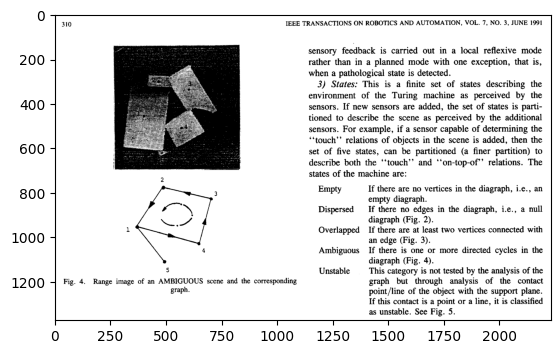

In [4]:
plt.imshow(bitmap, cmap="gray")

Imagem invertida


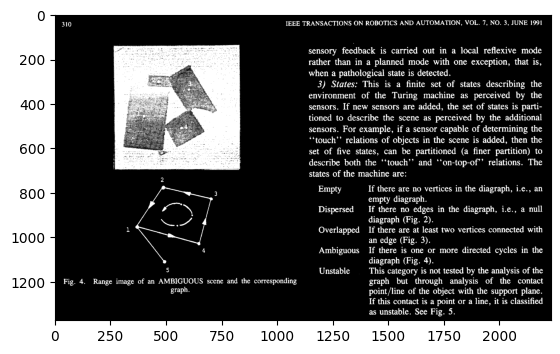

In [5]:
plt.imshow(bitmap_inverted, cmap="gray")

# Passo 1: Dilatação horizontal


Usando um elemento estruturante de 1 pixel de altura e 100 pixels de largura, percebemos que as palavras se alongam no eixo horizontal, formando um bloco único.


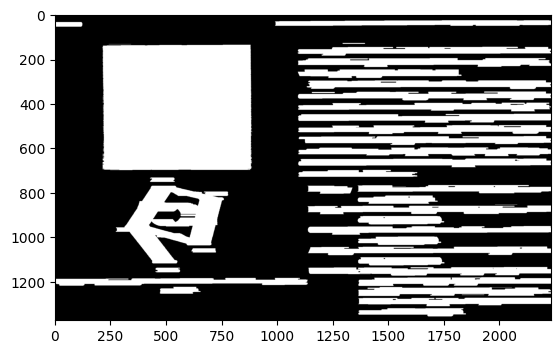

In [6]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 1))

img_dilation1 = cv2.dilate(bitmap_inverted, kernel, iterations=1)

plt.imshow(img_dilation1, cmap="gray")

# Passo 2: Erosão horizontal


Usando o mesmo elemento estruturante de 1 pixel de altura e 100 pixels de largura, agora percebemos que a erosão refinou o resultado, removendo alguns pixels e deixando os blocos menores.


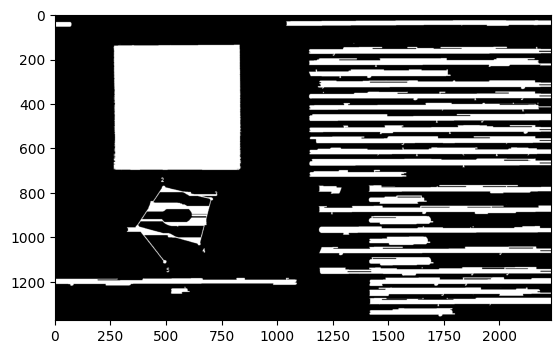

In [7]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 1))

img_erode2 = cv2.erode(img_dilation1, kernel, iterations=1)

plt.imshow(img_erode2, cmap="gray")

# Passo 3: Dilatação vertical


Agora, vamos repetir o processo de dilatação, mas com um elemento estruturante de 200 pixels de altura e 1 de largura. Percebemos agora um alongamento das palavras na vertical.


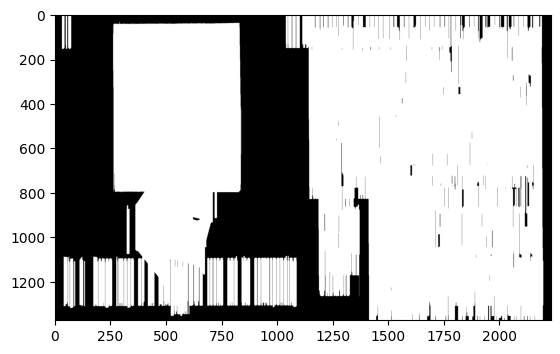

In [8]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 200))

img_dilation3 = cv2.dilate(bitmap_inverted, kernel, iterations=1)

plt.imshow(img_dilation3, cmap="gray")

# Passo 4: Erosão vertical


Repetindo o processo para a erosão, temos um resultado mais refinado.


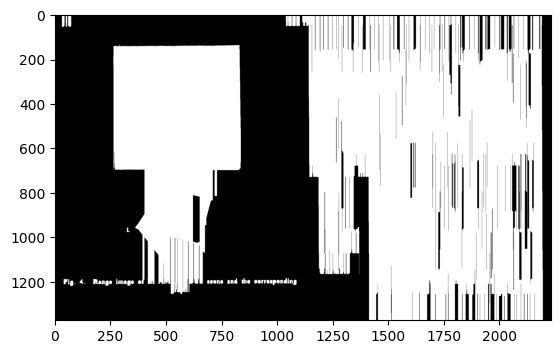

In [9]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 200))

img_erode4 = cv2.erode(img_dilation3, kernel, iterations=1)

plt.imshow(img_erode4, cmap="gray")

# Passo 5: Intersecção dos resultados (2) e (4)


Agora podemos fazer um merge nos resultados usando uma operação AND. A ideia é consolidar os resultados nas duas direções.


Como a gente está representando a imagem de maneira binária, a operação pode ser expressada como uma simples multiplicação.


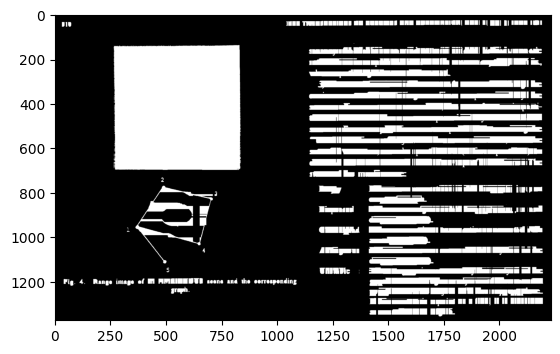

In [10]:
img_merge5 = img_erode4 * img_erode2

plt.imshow(img_merge5, cmap="gray")

# Passo 6: Fechamento do resultado


Conseguimos perceber que após o merge, temos a presença de alguns buracos dentro dos objetos. Para minimizar esse problema, realizamos uma operação de fechamento usando um elemento estruturante de 1 pixel de altura e 30 pixels de largura.


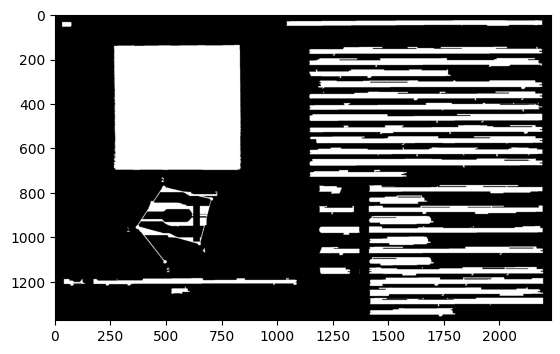

In [11]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 1))

img_closing6 = cv2.morphologyEx(img_merge5, cv2.MORPH_CLOSE, kernel)

plt.imshow(img_closing6, cmap="gray")

# Passo 7: Identificar componentes conexos


Queremos achar a caixas que representam os componentes conectados. Para achar tais regiões, usamos OpenCV a função `connectedComponentsWithStats()`. Para cada componente, ele retorna o menor retângulo possível para o componente caber.


In [12]:
nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(
    img_closing6)
print("# of boxes:", nlabels)

# of boxes: 54


# Passos 8 e 9: Cálculos


Agora, para cada retângulo, iremos calcular a razão entre o número de pixels pretos e o total de pixels, e a razão entre o número de transições verticais e horizontais e o número total de pixels.


Criei essa função auxiliar para contar as transições.


In [13]:
def count_transitions(img):
    assert len(np.unique(img)) <= 2, "Image is not binary"
    black_pixel = 0

    # template: white --> black
    template = [1, 0]

    row_length = img.shape[1]
    if row_length % 2 != 0:
        row_length = row_length-1

    transitions = 0
    for row in img:
        for i in range(row_length):
            if np.all(template == row[i: i+2]):
                transitions += 1
    return transitions

Transformamos a imagem em RGB para desenharmos os retãngulos depois.


In [14]:
rgb = np.zeros((bitmap.shape[0], bitmap.shape[1], 3))
rgb[:, :, 0] = bitmap
rgb[:, :, 1] = bitmap
rgb[:, :, 2] = bitmap

Aqui fazemos os cáculos de razão para cada retângulo e aplicamos uma heurística para determinar se o componente é válido ou não.


In [15]:
valid_transition_ratio = []
valid_pixel_ratio = []

#  para cada retângulo envolvendo um objeto, calcule:
for count, box in enumerate(stats):
    l = box[0]
    t = box[1]
    r = box[0] + box[2]
    b = box[1] + box[3]

    # pegar o retângulo
    img_patch = img_closing6[t:b, l:r]
    real_patch = bitmap[t:b, l:r]

    n_pixels_box = img_patch.shape[0] * img_patch.shape[1]

    n_white_pixels = np.count_nonzero(real_patch)
    n_black_pixels = n_pixels_box - n_white_pixels
    pixel_ratio = n_black_pixels / n_pixels_box

    ht = count_transitions(real_patch)
    vt = count_transitions(real_patch.T)

    transition_ratio = (ht + vt) / n_pixels_box

    # print usado para debug
    # print("# Box", count, "# White pixels:", n_white_pixels, "# Black pixels:", n_black_pixels, "# Pixel ratio:", pixel_ratio, "Transition ratio:", transition_ratio)

    if (pixel_ratio >= 0.19 and pixel_ratio <= 0.38) and (transition_ratio >= 0.065 and transition_ratio < 0.13):
        cv2.rectangle(rgb, (l, t), (r, b), (255, 0, 255), 2)

        valid_pixel_ratio.append(pixel_ratio)
        valid_transition_ratio.append(transition_ratio)

Desenhando os retângulos, percebemos que o resultado foi muito bom, conseguindo identificar as linhas principais do texto.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


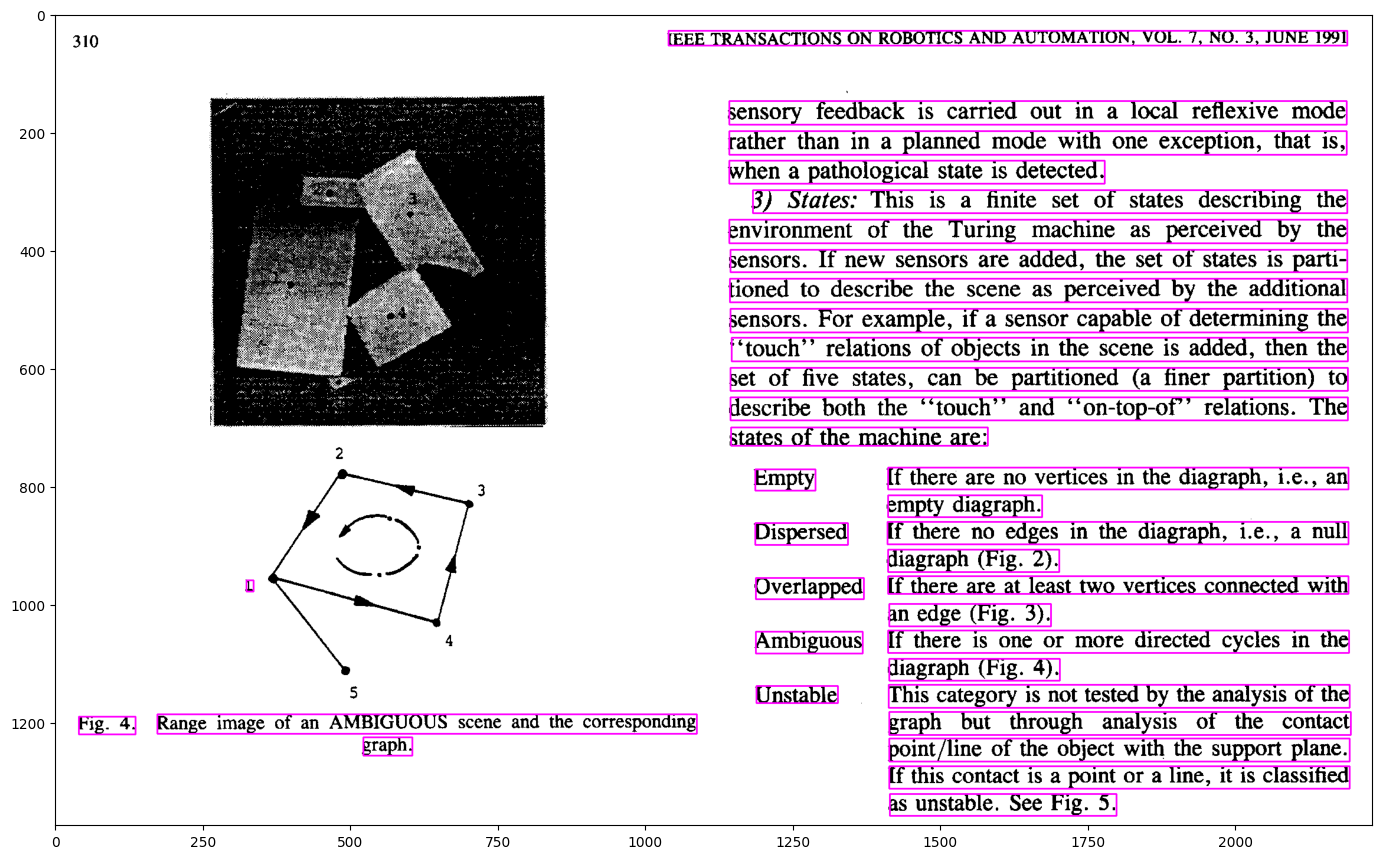

In [16]:
plt.figure(figsize=(17, 17))
plt.imshow(rgb)

O algoritmo calculou o total de 35 linhas. O documento tem 28 linhas. Essa diferença se deve ao fato de algumas palavras estarem muito afastadas, como na tabulação de "Empty". Portanto, a dilatação na horizontal não foi capaz de juntar em um bloco único.


In [17]:
print("Total of lines:", len(valid_pixel_ratio))

Total of lines: 35


# Passo 10: Contar palavras


Para contar o total de palavras, decidi refazer todos passos anteriores, pois vamos utilizar diferentes tamanhos de elementos estruturantes.


## Passo 1: Dilatação horizontal


Dessa vez, usaremos um elemento estruturante de 1 pixel de altura e 12 pixels de largura, para juntar as letras de uma mesma palavra, mas tomando cuidado para não juntar palavras muito próximas.


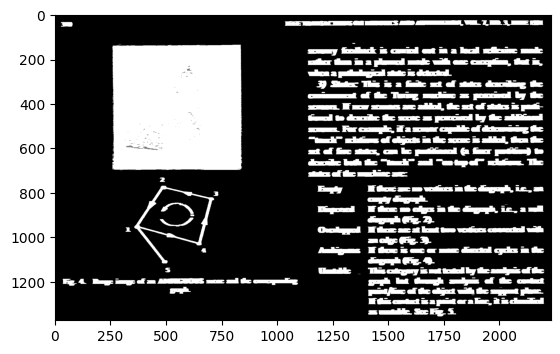

In [18]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (12, 1))

img_dilation1 = cv2.dilate(bitmap_inverted, kernel, iterations=1)

plt.imshow(img_dilation1, cmap="gray")

## Passo 2: Erosão horizontal


Usamos o mesmo elemento estruturante para a erosão, para refinarmos o resultado.


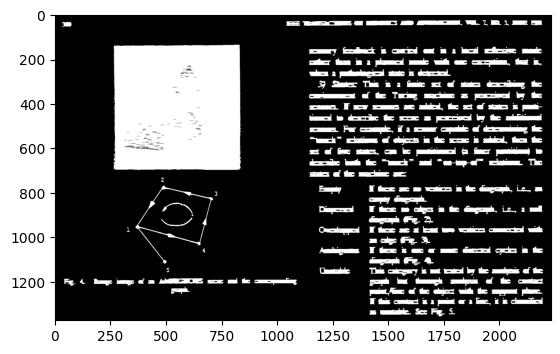

In [19]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (12, 1))

img_erode2 = cv2.erode(img_dilation1, kernel, iterations=1)

plt.imshow(img_erode2, cmap="gray")

## Passo 3: Dilatação vertical


Agora usamos um elemento estruturante de 4 pixels de altura e 1 pixel de largura.


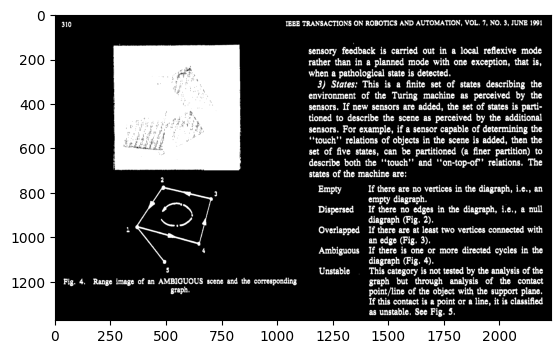

In [20]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 4))

img_dilation3 = cv2.dilate(bitmap_inverted, kernel, iterations=1)

plt.imshow(img_dilation3, cmap="gray")

## Passo 4: Erosão vertical


Usamos o mesmo elemento estruturante para refinar o resultado.


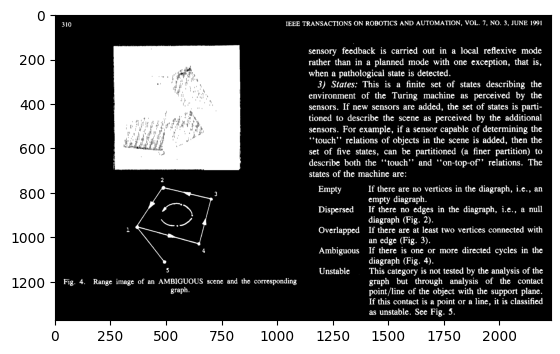

In [21]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 4))

img_erode4 = cv2.erode(img_dilation3, kernel, iterations=1)

plt.imshow(img_erode4, cmap="gray")

## Passo 5: Intersecção dos resultados (2) e (4)


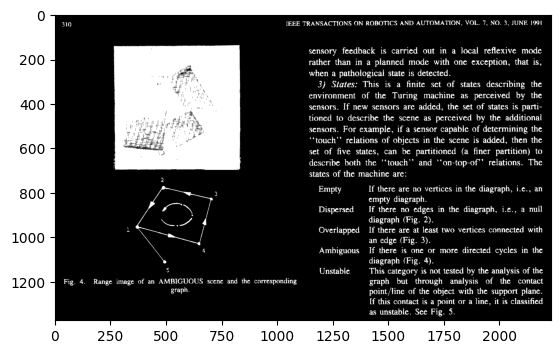

In [22]:
img_merge5 = img_erode4 * img_erode2

plt.imshow(img_merge5, cmap="gray")

## Passo 6: Fechamento do resultado


De novo, fazemos o fechamento para preencher buracos formados no merge.


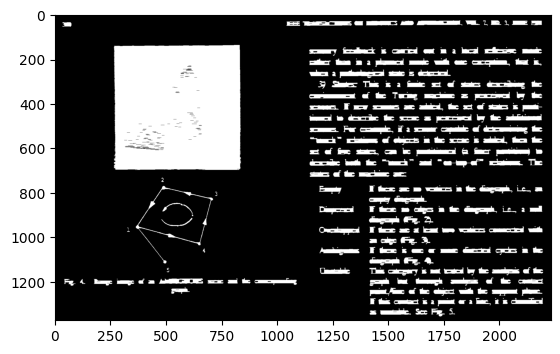

In [23]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (12, 1))

img_closing6 = cv2.morphologyEx(img_merge5, cv2.MORPH_CLOSE, kernel)

plt.imshow(img_closing6, cmap="gray")

## Passo 7: Identificar componentes conexos


In [24]:
nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(
    img_closing6)
print("# of boxes:", nlabels)

# of boxes: 316


## Passos 8 e 9: Cálculos


Transformando a imagem original para RGB, para desenhar os retãngulos.


In [25]:
rgb = np.zeros((bitmap.shape[0], bitmap.shape[1], 3))
rgb[:, :, 0] = bitmap
rgb[:, :, 1] = bitmap
rgb[:, :, 2] = bitmap

Novamente refazemos os cálculos para achar as razões e utilizamos uma heurística para fazer a contagem de palavras.


In [26]:
n_words = 0

#  para cada retângulo envolvendo um objeto, calcule:
for count, box in enumerate(stats):
    l = box[0]
    t = box[1]
    r = box[0] + box[2]
    b = box[1] + box[3]

    # pegar o retângulo
    img_patch = img_closing6[t:b, l:r]
    real_patch = bitmap[t:b, l:r]
    n_pixels_box = img_patch.shape[0] * img_patch.shape[1]

    n_white_pixels = np.count_nonzero(real_patch)
    n_black_pixels = n_pixels_box - n_white_pixels
    pixel_ratio = n_black_pixels / n_pixels_box

    ht = count_transitions(real_patch)
    vt = count_transitions(real_patch.T)
    transition_ratio = (ht + vt) / n_pixels_box

    # print usado como debug
    # print("# Box", count, "# White pixels:", n_white_pixels, "# Black pixels:", n_black_pixels, "# Pixel ratio:", pixel_ratio, "Transition ratio:", transition_ratio)

    if (pixel_ratio >= 0.1 and pixel_ratio <= 0.62) and transition_ratio >= 0.068:
        cv2.rectangle(rgb, (l, t), (r, b), (0, 255, 0), 2)

        n_words += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


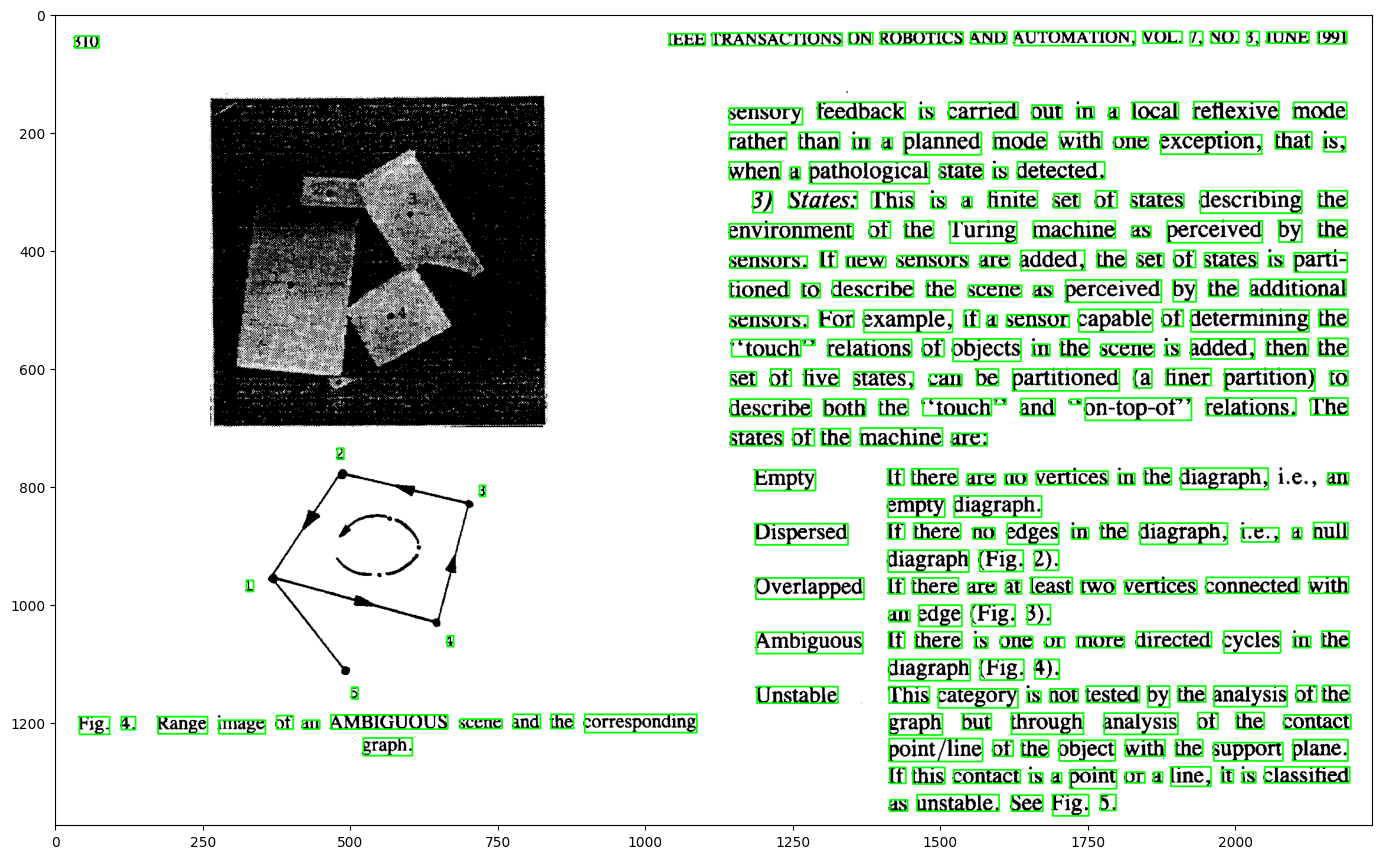

In [27]:
plt.figure(figsize=(17, 17))
plt.imshow(rgb)

Eu contei aproximadamente 240 palavras no texto. O algoritmo encontrou 244, de um total de 316 possibilidades.


In [28]:
print("Number of words:", n_words)

Number of words: 244


# Discussões


Apesar de termos resultados bons para essa iamgem, é importante notar que nem sempre teríamos o mesmo resultado para outros textos. Utilizamos heurísticas simples para classificação, portanto é de se esperar que documentos mais caóticos resultem diferentes. Por exemplo, documentos com diferentes tamanhos de texto, tabulações diferentes, etc.


Uma forma de conseguirmos generalizar melhor esse algoritmo seria com um aprendizado de máquina, onde seria possível se adaptar às regiões semelhantes e clusterizar os objetos. Por exemplos, clusterizar títulos, parágrafos, etc. Porém ainda estaríamos limitados na capacidade da máquina encontrar componentes semelhantes.
